<a href="https://colab.research.google.com/github/Vaibhav21pandit/Pytorch_Rally/blob/master/Torch_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip


--2020-06-10 11:01:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   137MB/s    in 0.5s    

2020-06-10 11:01:50 (137 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cats_and_dogs_filtered/vectorize.py  
replace cats_and_dogs_filtered/validation/dogs/dog.2127.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
replace cats_and_dogs_filtered/validation/dogs

In [ ]:
!ls cats_and_dogs_filtered/

train  validation  vectorize.py


TORCH SIMPLE MODEL



In [ ]:
import torch
from torchvision import models,datasets,transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import os

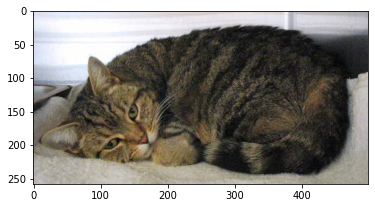

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
path='/content/cats_and_dogs_filtered'

for image in os.listdir(path+'/train/'+'/cats/'):
  image_path=path+'/train/'+'/cats/'+image
  im=Image.open(image_path)
  plt.imshow(im)
  break

In [ ]:
!ls cats_and_dogs_filtered

train  validation  vectorize.py


In [ ]:
path='/content/cats_and_dogs_filtered'
normalize=transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
transform={
    'train':transforms.Compose([transforms.Resize((128,128))
                                ,transforms.RandomGrayscale(p=0.3)
                                ,transforms.RandomHorizontalFlip()
                               ,transforms.ToTensor()
                               ,normalize]),
    'validation':transforms.Compose([transforms.Resize((128,128))
                               ,transforms.ToTensor()
                               ,normalize])
            }



dataset={
    'train':datasets.ImageFolder( path+'/train',transform=transform['train']),
    'validation':datasets.ImageFolder(path+'/validation',transform=transform['validation'])
}

dataloaders={
    'train':DataLoader(dataset['train'],batch_size=128,shuffle=True),
    'validation':DataLoader(dataset['validation'],batch_size=32,shuffle=False)
}


In [ ]:
# for i ,(inputs,labels) in enumerate(dataloaders['train']):
#   dataloaders['train'][i]=(inputs.cuda(),labels.cuda())




In [ ]:
models.resnet18().parameters

In [ ]:
model=models.resnet18(pretrained=True)
for param in model.parameters():
  param.set_trainable=True
model.fc=nn.Sequential(
    # nn.Linear(2048,512)
    # ,nn.ReLU(inplace=True)
    nn.Linear(512,128)
    ,nn.ReLU(inplace=False),
    nn.Linear(128,2))


In [ ]:
#defining optimizer,LR and loss
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.fc.parameters())

In [ ]:
# #training Loop
# num_epochs=10
# def train(model,dataloaders,loss_func,optimizer):
#   accuracy=[]
  
#   for epoch in range(num_epochs):
    
#     print(f'{epoch+1}/{num_epochs}')
#     print('-.'*15)
#     for phase in ['train','validation']:
#       if phase=='train':
#         model.train()
#       else:
#         model.eval()
#       running_loss=0.0
#       running_corrects=0
#       for i,(inputs,labels) in enumerate(dataloaders[phase]):
#         inputs=inputs.cuda()
#         labels=labels.cuda()
#         outputs=model(inputs).cuda()
#         loss=loss_func(outputs,labels)
#         if phase=='train':
#           optimizer.zero_grad()
#           loss.backward()
#           optimizer.step()
#         _,preds=torch.max(outputs,1)
#         # print(type(labels[1]))
#         running_corrects+=torch.sum(preds==labels)
#         print(running_corrects)
#     epoch_accuracy=running_corrects.item()/len(dataloaders[phase].dataset)
#     print(epoch_accuracy)

# train(model,dataloaders,loss_func,optimizer)


In [ ]:
import tqdm
def train_model(model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in (dataloaders[phase]):
                inputs = inputs.cuda()
#                 labels = list(map(float,labels))
                labels=torch.tensor(labels).cuda()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataset[phase])
            epoch_acc = running_corrects.double() / len(dataset[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model


Poutyne Library

In [ ]:
!pip install poutyne

     |████████████████████████████████| 102kB 2.5MB/s 


In [ ]:
from poutyne.framework import Model, ModelCheckpoint, BestModelRestore, CSVLogger, Experiment
from poutyne import torch_to_numpy, set_seeds

In [ ]:
modelwa = Model(model, optimizer, loss_func, batch_metrics=['accuracy'], epoch_metrics=['f1'])
modelwa.to('cuda:0')

In [ ]:
data={
    'inputs':[],
    'labels':[]
}
for (inputs,labels) in dataloaders['train']:
  data['inputs'].append(inputs.cuda())
  data['labels'].append(labels.cuda())


In [ ]:
modelwa.fit_generator(dataloaders['train'], dataloaders['validation'], epochs=1)
# modelwa.fit(data['inputs'],data['labels'],batch_size=32,epochs=5)

Epoch 1/1 22.23s Step 16/16: loss: 0.435991, acc: 79.150000, fscore_micro: 0.791500, val_loss: 0.189488, val_acc: 92.500000, val_fscore_micro: 0.925000


[{'acc': 79.15,
  'epoch': 1,
  'fscore_micro': 0.7915000319480896,
  'loss': 0.43599117374420165,
  'time': 22.23231669299821,
  'val_acc': 92.5,
  'val_fscore_micro': 0.925000011920929,
  'val_loss': 0.18948841321468354}]

In [ ]:
Model=train_model(model,loss_func,optimizer,3)

Epoch 1/3
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss: 0.3708, acc: 0.8390
validation loss: 0.2396, acc: 0.8860
Epoch 2/3
----------
train loss: 0.2305, acc: 0.9010
validation loss: 0.2310, acc: 0.9000
Epoch 3/3
----------
train loss: 0.2040, acc: 0.9075
validation loss: 0.1909, acc: 0.9210


In [ ]:
torch.save(Model.state_dict(),'./torch_resnet18.pth')

In [ ]:
modelwa=models.resnet18(pretrained=True).cuda()
for param in model.parameters():
  param.set_trainable=True
modelwa.fc=nn.Sequential(
    # nn.Linear(2048,512)
    # ,nn.ReLU(inplace=True)
    nn.Linear(512,128)
    ,nn.ReLU(inplace=False),
    nn.Linear(128,2)).cuda()
# torch.load(modelwa.load_state_dict('./torch_resnet18.pth'))
modelwa.load_state_dict(torch.load('./torch_resnet18.pth'))

<All keys matched successfully>

In [ ]:
!pip install pytorch-ignite


     |████████████████████████████████| 112kB 3.2MB/s 


In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator

In [ ]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
trainer = create_supervised_trainer(model, optimizer, loss_func, device=device)
train_evaluator = create_supervised_evaluator(model, device=device)
trainer.run(dataloaders['train'], max_epochs=4)


State:
	iteration: 64
	epoch: 4
	epoch_length: 16
	max_epochs: 4
	output: 0.1763554811477661
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 12

Captum Experiments

In [ ]:
!pip install captum

     |████████████████████████████████| 1.4MB 2.5MB/s 


In [ ]:
import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
#evaluation on a single Image
img=Image.open('/content/golden.jpg')
trans=transform['validation']
trans_img=trans(img)
input=(trans_img).cuda().unsqueeze(0)

In [ ]:
output=modelwa(input)
probs=F.softmax(output,dim=1)
prediction_score, pred_label_idx = torch.topk(probs, 1)

In [ ]:
integrated_gradients = IntegratedGradients(modelwa)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

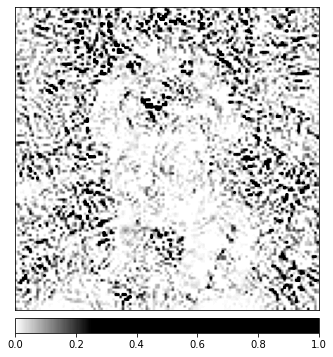

In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(trans_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='negative',
                             outlier_perc=1)

In [ ]:
###W&B Experiments###

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.4MB 3.5MB/s 
     |████████████████████████████████| 102kB 8.7MB/s 
     |████████████████████████████████| 102kB 8.7MB/s 
     |████████████████████████████████| 460kB 15.5MB/s 
     |████████████████████████████████| 112kB 26.3MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=7ef612789147f633b9217501830690025594f03265f0eac633c720aaeb1bba41
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.2-cp36-none-any.whl size=73605 sha256=6896ceeb8d8382cc19871a40beb114dcc310075d8665a48889dc0968273dd500
  Stored in directory: /root/.cache/pip/wheels/bc/ed/6c/028dea90d31b359cd2a7c8b0da4db80e41d24a59614154072e
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=b920